# Examen 1: Minería de Texto para Turismo

Guillermo Segura Gómez

Para este proyecto consideraremos el conjunto de datos recolectado por el equipo del Dr. Rafael Guerrero, profesor en la División de Ciencias Económico Administrativas de la Universidad de Guanajuato. Este conjunto de datos contiene un aproximado de diez mil opiniones de turistas en trip advisor en 10 sitios turísticos de la ciudad de Guanajuato. El objetivo es realizar las siguientes actividades y contestar las preguntas. Para esta tarea se puede usar cualquier librería o herramienta de Python (e.g., sklearn, keras, nltk, códigos de github de otras personas (citando), etc.). También puede reusar su código de tareas previas, o puede simplemente usar TfIdfVectorizer, CountVectorizer, etc. de sklearnt. 

Puede usar también SelectKBest como en el Lecture de DOR lo hizo el profesor, o usar su propio código de Chi2.Para estas actividades usted determine el número de features (palabras) de alguna forma según su intuición. Usualmente el top 10k con base en frecuencia podría ser buena elección si su hardware es suficiente para llevar a cabo las actividades. Sí su reducción es a 5k o menos términos, algo con base en Chi2, Ganancia de Información o valores TFIDFs podría venir mejor para no perder tanta información y llegar a buenas conclusiones.

## Actividades

**1. Construya estadísticas básicas respecto a la opinión de cada lugar turístico. Pre procese y limpie el texto según sus intuiciones y argumente brevemente sobre ello.**

**Considere scores de 4 a 5 como positivos, calificaciones de 3 como neutros y las de 2 a 1 como negativos. Es interesante ver:**

* (a) Promedios de calificación por lugar, y desviaciones estándar en los scores
* (b) Basado en palabras: longitud promedio de opiniones y desviaciones estándar
* (c) Histogramas de edades de opiniones por lugar
* (d) Histograma de tipo de visitantes (nacional o internacional) por lugar
* (e) Sugiere dos más interesantes para ti.

----

Lo primero que tenemos que hacer es cargar los datos en un **dataframe** de *pandas* esto ya que hace que sea muchísimo mas fácil trabajar los datos. Trabajamos con un diccionario que tenga los dataframes ya que el contenido del archivo xlsx son bastantes hojas.

Librerías necesarias

In [1]:
# Funciones necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re
import warnings
from wordcloud import WordCloud # Nube de palabras


# NLTK
import nltk
nltk.data.path.append('/Users/guillermo_sego/anaconda3/nltk_data/') # path
from nltk.corpus import stopwords

# Tokienizador
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer() # Inicializar tokenizer

# Para análisis de sentimientos
from textblob import TextBlob

# Scikit
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [2]:
# Cargar el archivo xlsx
xlsx = pd.ExcelFile('/Users/guillermo_sego/Desktop/Segundo Semestre/PLN/Data/Opiniones Tripadvisor_nlp2023(1).xlsx', engine='openpyxl')

# Diccionario para almacenar DataFrames
dfs = {}

# Leer cada hoja en un DataFrame y almacenarlo en el diccionario
for sheet_name in xlsx.sheet_names:
    dfs[sheet_name] = pd.read_excel(xlsx, sheet_name)

In [3]:
# Mostrar las primeras filas del DataFrame
print(dfs["Alhóndiga 930"].head())

      Género  Edad Nacional ó Internacional Calificación  Escala  \
0  Masculino  59.0                 Nacional    Excelente       5   
1  Masculino  32.0                 Nacional    Excelente       5   
2  Masculino  18.0                 Nacional    Muy bueno       4   
3   Femenino  30.0            Internacional    Excelente       5   
4   Femenino  25.0                 Nacional    Excelente       5   

   Número de aportaciones                   Título de la opinión  \
0                     267                 "Gran sitio histórico"   
1                      61                      "Excelente museo"   
2                      50   "Presenciar el lugar de la tragedia"   
3                      69  "EL CORAZÓN DE LA HISTORIA DE MÉXICO"   
4                      22               "Viaje diver-cultural!!"   

                                             Opinión    País   Idioma  \
0  "Fue construida a finales del siglo XVIII, en ...  México  Español   
1  "Parada obligatoria en tu visita 

Con un dataframe de pandas podemos manejar las columnas de datos de manera sencilla para proceder con el análisis. Trabajamos en funciones para realizar algunas estadísticas básicas de los data frames.

In [38]:
# Función que realiza el promedio la calificación por lugar y desviación estándar
def PromDesDF(dataframe):

    # Calculamos el promedio
    cal = dataframe["Escala"].mean()

    # Calculamos desviación estándar
    std = dataframe["Escala"].std()

    print(f"Promedio de calificación: {cal:.2f}")
    print(f"Desviación estándar: {std:.2f}")
    print()

# Función para calcular la longitud promedio de las opiniones y su desviación estándar
def PromOpDF(dataframe):
    # Lista para almacenar las longitudes de las opiniones
    lenDocs = []

    # Calculamos la longitud de cada opinión
    for doc in dataframe["Opinión"]:
        # Tokenizamos
        aux = tokenizer.tokenize(doc)
        lenDocs.append(len(aux))

    # Convertimos la lista en un array de NumPy para hacer cálculos
    lenDocs_np = np.array(lenDocs)

    # Calculamos el promedio y desviación estándar
    promedio = lenDocs_np.mean()
    desviacion = lenDocs_np.std()

    print(f"Promedio de longitud de opiniones: {promedio:.2f}")
    print(f"Desviación estándar de longitud de opiniones: {desviacion:.2f}")
    print()

def PlotEdad(dataframe, lugar):
    # Graficamos
    plt.figure(figsize=(5, 3))
    plt.hist(dataframe["Edad"].dropna(), bins=15, color='blue', alpha=0.7)
    plt.title(f'Histograma de Edades para {lugar}')
    plt.xlabel('Edad')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()

    
def PlotTipoVisitante(dataframe, lugar):
    # Graficamos
    plt.figure(figsize=(6, 3))
    dataframe["Nacional ó Internacional"].value_counts().plot(kind='bar', color='green', alpha=0.7)
    plt.title(f'Tipo de Visitantes para {lugar}')
    plt.xlabel('Tipo de Visitante')
    plt.ylabel('Número de Visitantes')
    plt.grid(True)
    plt.show()

def SentimentAnalysis(dataframe):
    # Lista para guardar los sentimientos
    sentiments = []

    # Iteramos sobre las opiniones 
    for opinion in dataframe["Opinión"]:
        blob = TextBlob(opinion)
        sentiments.append(blob.sentiment.polarity) # Agregamos cada puntuación de sentimientos
    
    # Calculamos la media y std
    sentiments_np = np.array(sentiments)
    promedio_sentimiento = sentiments_np.mean()
    std_sentimiento = sentiments_np.std()

    print(f"Promedio de sentimiento: {promedio_sentimiento:.2f}")
    print(f"Desviación estándar de sentimiento: {std_sentimiento:.2f}")
    print()

    
def WordFrequency(dataframe):
    # Para guardar las palabras
    words = []
    for opinion in dataframe["Opinión"]:
        words.extend(re.findall(r'\b\w+\b', opinion.lower()))

    # Contamos las palabras mas comunes
    word_counts = Counter(words)
    most_common_words = word_counts.most_common(10)

    print("Palabras más comunes:")
    for word, freq in most_common_words:
        print(f"{word}: {freq}")
    print()


def PromNacInt(df):
    # Agrupa el DataFrame por la columna 'Nacional ó Internacional' y calcula la media de 'Escala'
    media_opiniones = df.groupby('Nacional ó Internacional')['Escala'].mean()

    print(media_opiniones)

Calculamos estadísticas básicas con las funciones implementadas

Estadísticas para: Basilica Colegiata 560

Promedio de calificación: 4.50
Desviación estándar: 0.67

Promedio de longitud de opiniones: 46.35
Desviación estándar de longitud de opiniones: 32.55



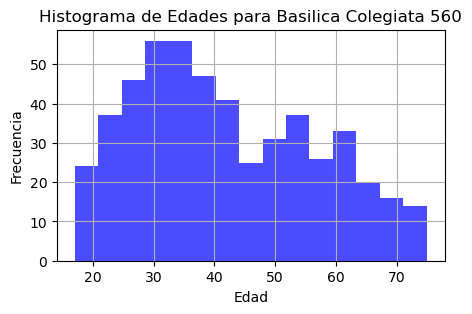

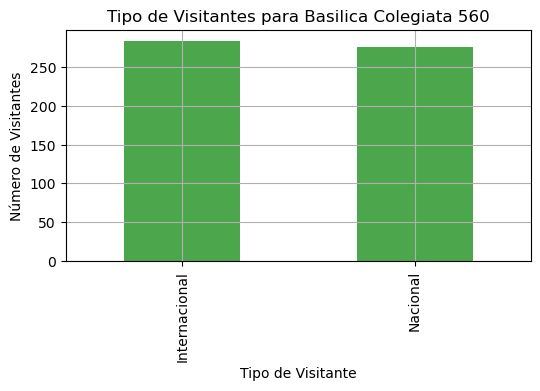

Promedio de sentimiento: 0.13
Desviación estándar de sentimiento: 0.22

Palabras más comunes:
de: 918
la: 751
the: 637
a: 470
y: 431
en: 416
es: 371
el: 324
que: 315
of: 298

Nacional ó Internacional
Internacional    4.496479
Nacional         4.503623
Name: Escala, dtype: float64
---------------
Estadísticas para: Mercado Hidalgo 600

Promedio de calificación: 3.95
Desviación estándar: 0.95

Promedio de longitud de opiniones: 53.68
Desviación estándar de longitud de opiniones: 38.05



Promedio de sentimiento: 0.13
Desviación estándar de sentimiento: 0.22

Palabras más comunes:
de: 914
the: 621
a: 593
y: 568
la: 478
and: 411
que: 398
es: 389
en: 384
el: 320

Nacional ó Internacional
Internacional    4.026578
Nacional         3.869565
Name: Escala, dtype: float64
---------------
Estadísticas para: Casa de Diego Rivera 698

Promedio de calificación: 4.24
Desviación estándar: 0.80

Promedio de longitud de opiniones: 56.77
Desviación estándar de longitud de opiniones: 33.55



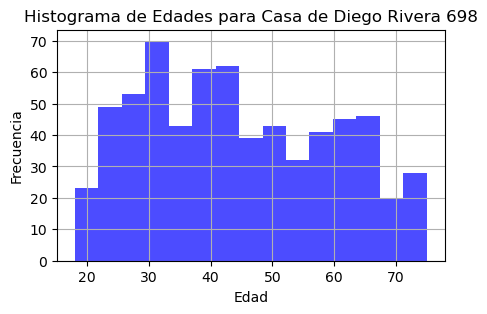

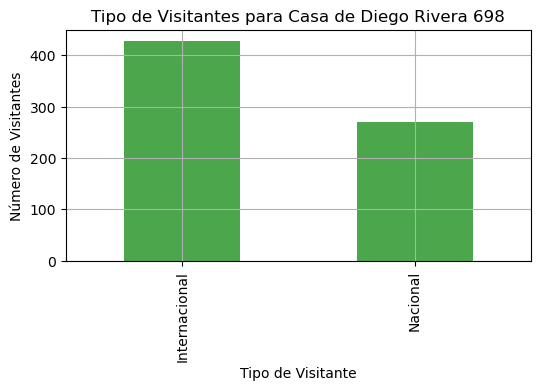

Promedio de sentimiento: 0.14
Desviación estándar de sentimiento: 0.19

Palabras más comunes:
de: 1135
the: 1032
of: 733
la: 705
a: 695
and: 572
diego: 537
rivera: 500
y: 495
que: 457

Nacional ó Internacional
Internacional    4.182243
Nacional         4.340741
Name: Escala, dtype: float64
---------------
Estadísticas para: Universidad de Guanajuato 900

Promedio de calificación: 4.60
Desviación estándar: 0.61

Promedio de longitud de opiniones: 41.49
Desviación estándar de longitud de opiniones: 22.25



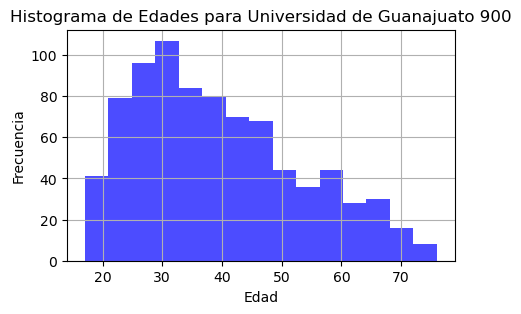

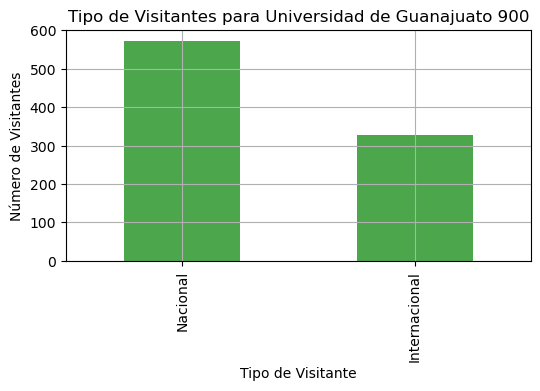

Promedio de sentimiento: 0.11
Desviación estándar de sentimiento: 0.23

Palabras más comunes:
de: 1539
la: 1302
y: 741
que: 684
es: 663
a: 605
the: 555
en: 521
el: 454
una: 448

Nacional ó Internacional
Internacional    4.422018
Nacional         4.706806
Name: Escala, dtype: float64
---------------
Estadísticas para: Alhóndiga 930

Promedio de calificación: 4.45
Desviación estándar: 0.75

Promedio de longitud de opiniones: 53.59
Desviación estándar de longitud de opiniones: 37.36



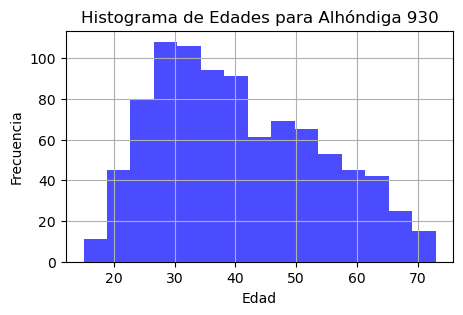

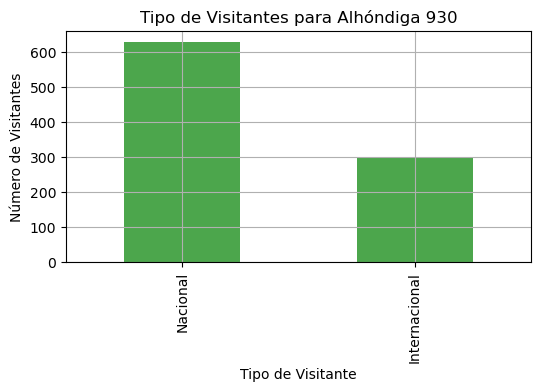

Promedio de sentimiento: 0.07
Desviación estándar de sentimiento: 0.16

Palabras más comunes:
de: 1924
la: 1430
the: 1121
que: 973
y: 821
a: 777
en: 673
es: 662
el: 635
un: 540

Nacional ó Internacional
Internacional    4.496667
Nacional         4.434921
Name: Escala, dtype: float64
---------------
Estadísticas para: Teatro Juárez 1,010

Promedio de calificación: 4.70
Desviación estándar: 0.52

Promedio de longitud de opiniones: 48.47
Desviación estándar de longitud de opiniones: 29.93



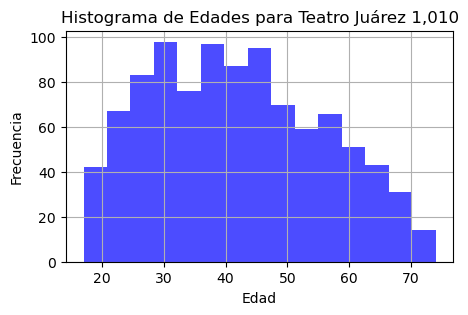

Promedio de sentimiento: 0.11
Desviación estándar de sentimiento: 0.20

Palabras más comunes:
de: 1602
la: 1141
y: 913
the: 906
a: 892
que: 792
el: 786
es: 758
en: 706
teatro: 514

Nacional ó Internacional
Internacional    4.608491
Nacional         4.771331
Name: Escala, dtype: float64
---------------
Estadísticas para: Jardín de la Unión 1,134

Promedio de calificación: 4.59
Desviación estándar: 0.61

Promedio de longitud de opiniones: 50.84
Desviación estándar de longitud de opiniones: 41.72



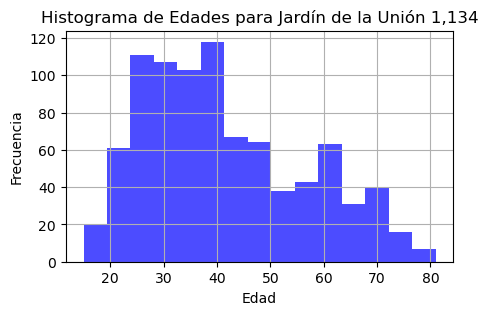

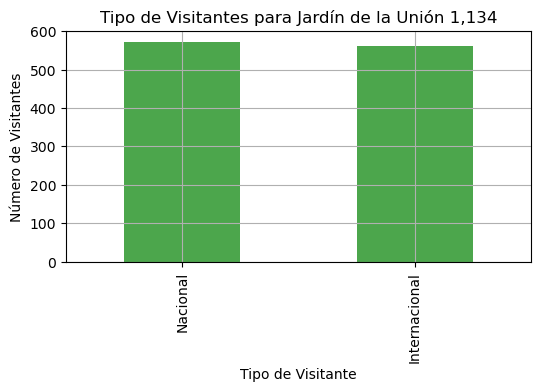

Promedio de sentimiento: 0.17
Desviación estándar de sentimiento: 0.25

Palabras más comunes:
de: 1682
the: 1443
a: 1177
y: 1080
la: 956
and: 921
el: 722
en: 703
of: 618
to: 574

Nacional ó Internacional
Internacional    4.58363
Nacional         4.59965
Name: Escala, dtype: float64
---------------
Estadísticas para: Callejón del Beso 1,360

Promedio de calificación: 4.00
Desviación estándar: 0.97

Promedio de longitud de opiniones: 52.45
Desviación estándar de longitud de opiniones: 36.60



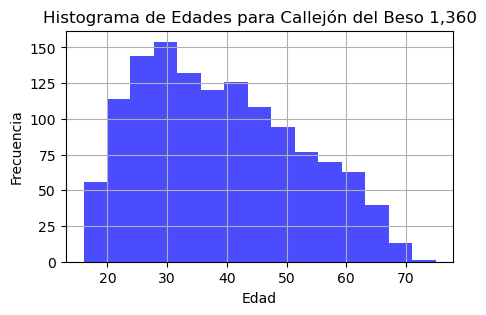

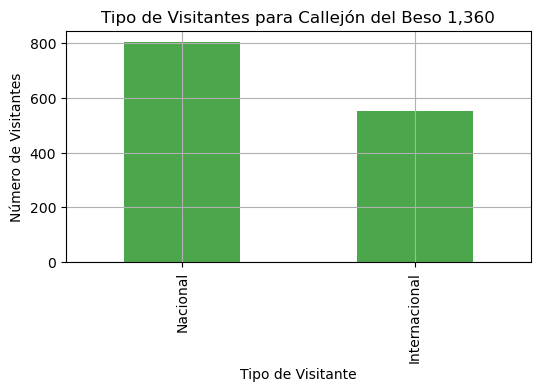

Promedio de sentimiento: 0.06
Desviación estándar de sentimiento: 0.16

Palabras más comunes:
de: 1978
la: 1801
que: 1657
y: 1474
a: 1360
es: 1171
el: 1076
en: 1054
the: 937
un: 845

Nacional ó Internacional
Internacional    3.853791
Nacional         4.093052
Name: Escala, dtype: float64
---------------
Estadísticas para: Monumento Pípila 1,620

Promedio de calificación: 4.38
Desviación estándar: 0.77

Promedio de longitud de opiniones: 54.80
Desviación estándar de longitud de opiniones: 40.15



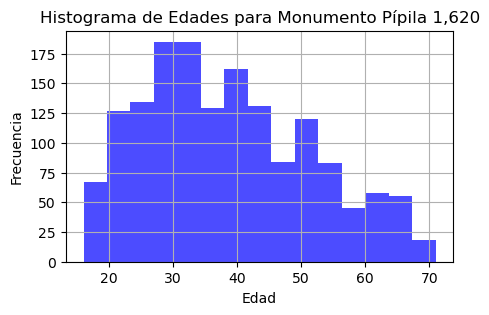

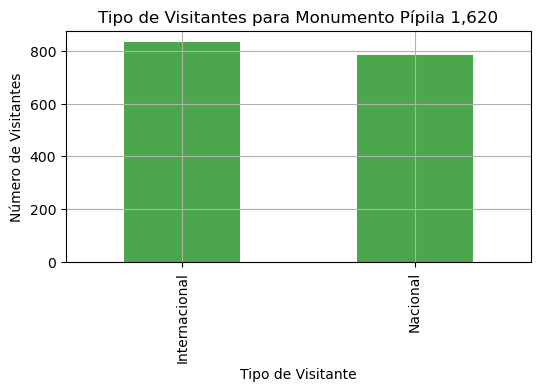

Promedio de sentimiento: 0.11
Desviación estándar de sentimiento: 0.22

Palabras más comunes:
la: 2854
de: 2815
the: 2426
el: 1517
a: 1488
que: 1411
y: 1339
es: 1320
en: 1034
ciudad: 879

Nacional ó Internacional
Internacional    4.426347
Nacional         4.326115
Name: Escala, dtype: float64
---------------
Estadísticas para: Museo de las Momias 1,650

Promedio de calificación: 3.68
Desviación estándar: 1.14

Promedio de longitud de opiniones: 67.15
Desviación estándar de longitud de opiniones: 51.98



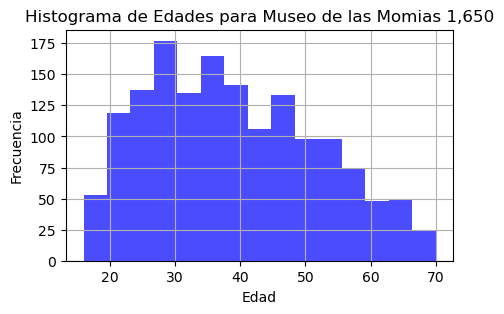

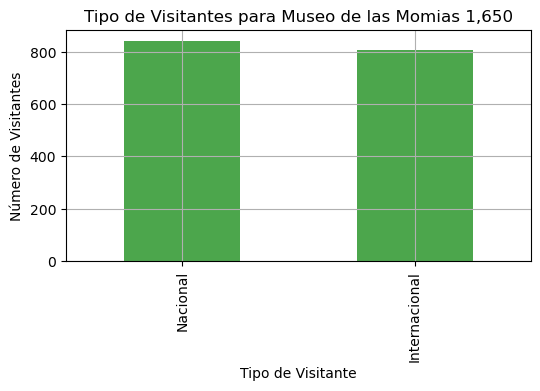

Promedio de sentimiento: 0.04
Desviación estándar de sentimiento: 0.17

Palabras más comunes:
de: 2833
que: 2273
the: 2027
a: 1923
la: 1747
y: 1734
es: 1483
el: 1408
en: 1347
no: 1314

Nacional ó Internacional
Internacional    3.705446
Nacional         3.646081
Name: Escala, dtype: float64
---------------


In [39]:
# Iteramos sobre cada lugar y su DataFrame en el diccionario
for lugar, df in dfs.items():
    print(f"Estadísticas para: {lugar}")
    print()
    PromDesDF(df)
    PromOpDF(df)
    PlotEdad(df, lugar)
    PlotTipoVisitante(df, lugar)
    SentimentAnalysis(df)
    WordFrequency(df)
    PromNacInt(df)

    print("---------------")

**Discusión**

Las calificaciones de los lugares en una escala del 1 al 5 oscilan entre 3.68 y 4.70, siendo calificaciones en su mayoría positivas. La calificación mas baja se la llevo el *museo de las momias* y la calificación mas alta la tiene el *teatro juarez*, aunque la desviación estándar del museo de las momias es la mas alta de todas, por lo que la calificación baja se puede deber a unas pocas opiniones que se salieron de la media que no les gusto el teatro. 

En cuanto a la distribución de las edades, en su mayoría los lugares fueron visitados por personas entre 20 y 40 años, siendo el grupo mas numeroso personas de 30 años. Los lugares con mas presencia de personas jóvenes (20 - 30 años) fueron por supuesto *la universidad de Guanajuato*, *el jardín de la unión* y el *mercado hidalgo* mientras que los lugares con una distribución mas uniforme de las edades fueron *el teatro Juarez* y *la casa Diego Rivera*.

Se tienen en la mayoría de lugares la misma presencia de opiniones nacionales e internacionales, destacando que en los lugares donde esto no pasa, las opiniones que son mayoría son las nacionales.

Para los análisis complementarios se propone un análisis de sentimientos simple utilizando la librería **TextBlob** la cual utiliza por defecto un clasificador entrenado con un modelo de Naive Bayes sobre un dataset de reseñas de películas.

TextBlob evalúa dos propiedades en el análisis de sentimientos:

* Polarity: Un valor flotante dentro del rango [-1.0, 1.0] donde -1.0 indica un sentimiento negativo y 1.0 indica un sentimiento positivo.
* Subjectivity: Un valor flotante dentro del rango [0.0, 1.0] donde 0.0 es muy objetivo y 1.0 es muy subjetivo.

En este caso solo medimos la medía y desviación estándar de la **polaridad** de los sentimientos. Por lo que los valores oscilan entre [-1, 1]. En su mayoría el análisis de sentimientos tiende a ser positivo, aunque la gran mayoría no pasa del valor 0.15, por lo que según el análisis las opiniones tienden a ser neutras. Esto en contraste con la calificación sugiere que las personas tienden a utilizar un lenguaje neutral en sus opiniones, aunque cuando se califica usan valores altos positivos, ya que los scores son muy positivos, mientras que las opiniones son muy neutras. Interesante de ver :o 

Sería interesante comparar este score entre nacionales e internacionales, tal vez la forma de escribir cambia.

El último análisis complementario es uno de palabras mas comunes, donde en su mayoría coincidió que fueron stopwords, como artículos. En el caso de la casa Diego Rivera fue mucho el uso de las palabras "Rivera" y "Diego" obvio por el titulo del lugar, aunque es interesante que el único lugar donde se mencionó el nombre dentro de las palabras mas comunes.

Se agrega un análisis adicional en el que se calcula la media de opiniones entre los grupos Nacional e Internacional, siendo muy parecidas las opiniones entre ambos grupos variando en distintos lugares.

**2. Utilizando una estrategia de feature selection (se sugiere $\chi^2$ o ganancia de información) visualice con [word_cloud](https://amueller.github.io/word_cloud/) nubes de palabras el top k (se sugiere 50) de palabras más relevantes para cada uno de los 10 lugares. Note que serán 10 nubes, una por lugar.**

Para realizar la nube de palabras con feature selection necesitamos aplicar una reducción de dimensionalidad a una matriz *término-documento* como una bow. Necesitamos entonces construir una matriz bow, (función que ya tenemos, de tareas anteriores), sin embargo voy a utilizar la librería scikit para este fin ya que nunca la he utilizado para construir una matriz bow. Utilizamos *TfidfVectorizer* de scikit-learn para convertir los textos limpios a una matriz TF-IDF.

Para realizar esto, necesitamos implementar una función que realicé el test de $\chi^2$ y nos de las palabras mas frecuentes para graficar los resultados en una nube de palabras. 

In [6]:
def chiSquare(dataframe, nCaract):

    sw = stopwords.words('spanish') 

    vectorizer = TfidfVectorizer(stop_words=sw)
    X = vectorizer.fit_transform(dataframe['Opinión'])

    # Usar y como etiquetas binarias para opiniones negativas
    y = (dataframe['Escala'])

    # Selección de características usando chi2
    selector = SelectKBest(chi2, k=nCaract) # No de características seleccionadas
    X_new = selector.fit_transform(X, y)

    # Obtener las características seleccionadas
    feature_names = np.array(vectorizer.get_feature_names_out())
    selected_features = feature_names[selector.get_support()]

    # Crear y mostrar la nube de palabras
    word_freq = dict(zip(selected_features, np.asarray(X_new.sum(axis=0)).ravel()))
    return word_freq

Gráfica para: Basilica Colegiata 560


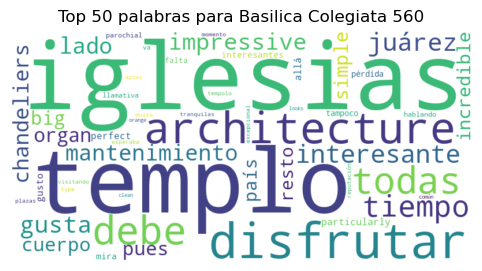

---------------
Gráfica para: Mercado Hidalgo 600


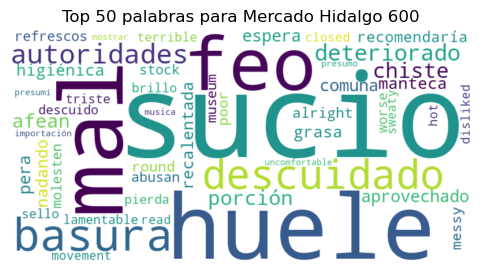

---------------
Gráfica para: Casa de Diego Rivera 698


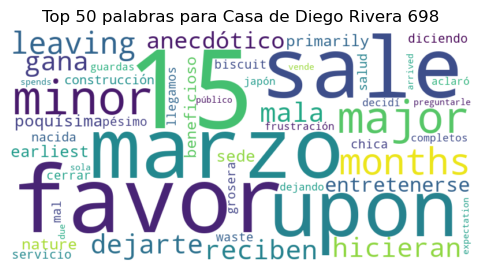

---------------
Gráfica para: Universidad de Guanajuato 900


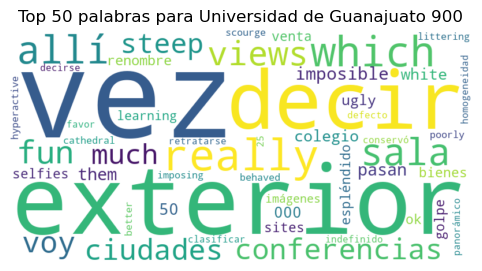

---------------
Gráfica para: Alhóndiga 930


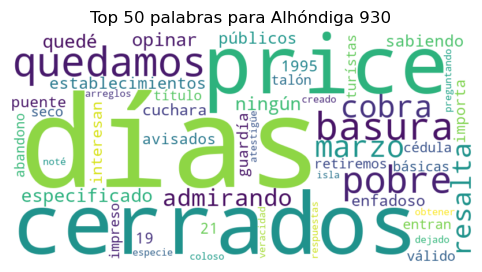

---------------
Gráfica para: Teatro Juárez 1,010


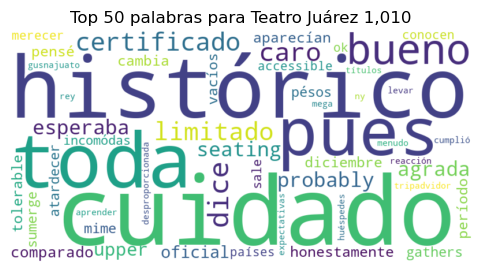

---------------
Gráfica para: Jardín de la Unión 1,134


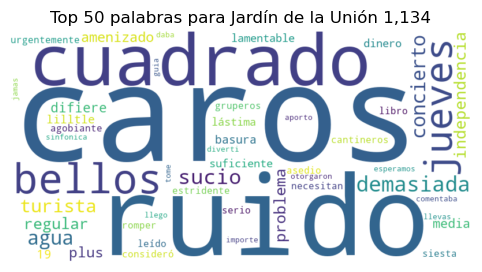

---------------
Gráfica para: Callejón del Beso 1,360


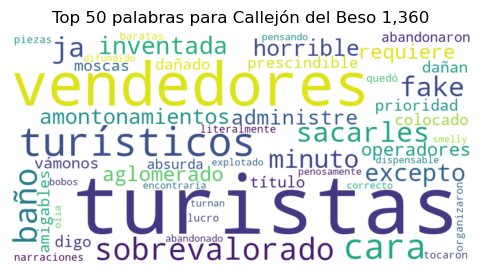

---------------
Gráfica para: Monumento Pípila 1,620


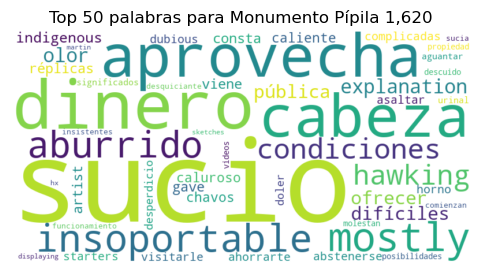

---------------
Gráfica para: Museo de las Momias 1,650


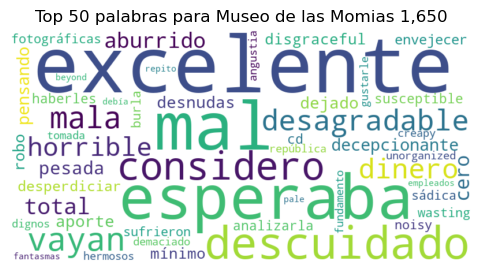

---------------


In [7]:
# Iteramos sobre cada lugar y su DataFrame en el diccionario
for lugar, df in dfs.items():
    print(f"Gráfica para: {lugar}")

    # Llamamos a la función
    word_freq = chiSquare(df, nCaract=50)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(8, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Top 50 palabras para {lugar}')
    plt.axis("off")
    plt.show()

    print("---------------")

**Discusión**

Vemos palabras asociadas con los lugares, tanto en inglés como en español. Por ejemplo en el monumento del pipila, una palabra es *caluroso* lo cual es indicativo de como se tiene que subir para llegar ahí, en medio del calor. O en el teatro Juarez que se resalta la arquitectura y lo cuidado que esta el edificio. La gran mayoría reflejan en las palabras mas probables características negativas de los lugres, por ejemplo en el mercado Hidalgo y en el monumento al pipila, *sucio*. Incluso por ejemplo en el jardín de la unión, existe la palabra *caros* y *jueves* lo cual indica que las personas suelen visitarlo en jueves y les parece caro. Definitivamente se puede saber muchísimo con este tipo de análisis. 

**3. Para cada uno de los 10 sitios turísticos, haga un descubrimiento automático de los 3 tópicos con LSA (investiga, estudia y aprende por su cuenta LSA) más relevantes y 10 palabras contenidas en cada tópico de cada uno de los siguientes subgrupos:**

* (a) Hombres
* (b) Mujeres
* (c) Turistas Nacionales
* (d) Turistas Internacionales
* (e) Jovénes (elige un rango de edad interesante con base en sus estadísticas)
* (f) Mayores (elige un rango de edad interesante con base en sus estadísticas)

Como en el ejercicio anterior, realizamos las funciones para al final solo aplicar un ciclo for que haga esto para todos los lugares.

In [40]:
# Función para construir una matriz tipo tfidf
def LSAforDF(dataframe, tipoD, GrupoDF, n_components):
    
    # Subgrupo de genero
    subgrupo = dataframe[dataframe[GrupoDF] == tipoD]

    # Configuración de stopwords
    spanish_stopwords = stopwords.words('spanish')

    # Inicializar el vectorizador TFIDF
    vectorizer = TfidfVectorizer(stop_words=spanish_stopwords)

    # Construir matriz TFIDF
    X = vectorizer.fit_transform(subgrupo['Opinión'])

    # Aplicar LSA
    svd_model = TruncatedSVD(n_components=n_components, random_state=42)
    lsa_matrix = svd_model.fit_transform(X)

    # Identificar tópicos y palabras clave
    terms = vectorizer.get_feature_names_out()
    for i, comp in enumerate(svd_model.components_):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)[:10]
        print("Tópico " + str(i+1) + ": ")
        print([term for term, _ in sorted_terms])

In [41]:
# Iteramos sobre cada lugar y su DataFrame en el diccionario
for lugar, df in dfs.items():
    print(f"Estadísticas para: {lugar}")
    
    # Análisis de LSA
    print("LSA para el género masculino")
    LSAforDF(df, tipoD = "Masculino", GrupoDF='Género', n_components=2)

    print()

    print("LSA para el género femenino")
    LSAforDF(df, tipoD = "Femenino", GrupoDF='Género', n_components=2)

    print("---------------")

Estadísticas para: Basilica Colegiata 560
LSA para el género masculino
Tópico 1: 
['the', 'of', 'and', 'is', 'in', 'it', 'to', 'this', 'you', 'church']
Tópico 2: 
['ciudad', 'guanajuato', 'iglesia', 'noche', 'centro', 'lugar', 'hermosa', 'basílica', 'bonita', 'visitar']

LSA para el género femenino
Tópico 1: 
['the', 'and', 'of', 'is', 'in', 'to', 'it', 'beautiful', 'this', 'you']
Tópico 2: 
['ciudad', 'hermosa', 'iglesia', 'guanajuato', 'basílica', 'centro', 'dentro', 'bonita', 'noche', 'arquitectura']
---------------
Estadísticas para: Mercado Hidalgo 600
LSA para el género masculino
Tópico 1: 
['the', 'and', 'of', 'to', 'is', 'you', 'in', 'market', 'it', 'for']
Tópico 2: 
['mercado', 'comida', 'lugar', 'artesanías', 'comprar', 'comer', 'si', 'recuerdos', 'precios', 'variedad']

LSA para el género femenino
Tópico 1: 
['the', 'and', 'to', 'of', 'it', 'is', 'you', 'market', 'food', 'in']
Tópico 2: 
['mercado', 'lugar', 'comida', 'si', 'comprar', 'dulces', 'artesanías', 'comer', 'buen',

In [42]:
# Iteramos sobre cada lugar y su DataFrame en el diccionario
for lugar, df in dfs.items():
    print(f"Estadísticas para: {lugar}")
    
    # Análisis de LSA
    print("LSA para turistas nacionales")
    LSAforDF(df, tipoD = "Nacional", GrupoDF='Nacional ó Internacional', n_components=2)

    print()

    print("LSA para turistas internacionales")
    LSAforDF(df, tipoD = "Internacional", GrupoDF='Nacional ó Internacional', n_components=2)

    print("---------------")

Estadísticas para: Basilica Colegiata 560
LSA para turistas nacionales
Tópico 1: 
['guanajuato', 'ciudad', 'hermosa', 'lugar', 'centro', 'bonita', 'basílica', 'iglesia', 'arquitectura', 'noche']
Tópico 2: 
['the', 'of', 'and', 'is', 'in', 'to', 'this', 'it', 'beautiful', 'from']

LSA para turistas internacionales
Tópico 1: 
['the', 'and', 'of', 'is', 'in', 'it', 'to', 'you', 'this', 'beautiful']
Tópico 2: 
['ciudad', 'iglesia', 'noche', 'centro', 'hermosa', 'guanajuato', 'basílica', 'plaza', 'amarillo', 'día']
---------------
Estadísticas para: Mercado Hidalgo 600
LSA para turistas nacionales
Tópico 1: 
['mercado', 'comida', 'lugar', 'si', 'artesanías', 'comprar', 'dulces', 'comer', 'precios', 'guanajuato']
Tópico 2: 
['the', 'and', 'to', 'is', 'you', 'of', 'in', 'it', 'this', 'market']

LSA para turistas internacionales
Tópico 1: 
['the', 'and', 'of', 'to', 'is', 'you', 'market', 'in', 'it', 'for']
Tópico 2: 
['mercado', 'lugar', 'comida', 'comprar', 'recuerdos', 'comer', 'puede', 'bu

Modificamos ligeramente la función para tener los campos de edad.

In [44]:
def LSAforDF(dataframe, min_age, max_age, n_components):
    # Subgrupo por rango de edad
    subgrupo = dataframe[(dataframe['Edad'] >= min_age) & (dataframe['Edad'] <= max_age)]

    # Configuración de stopwords
    spanish_stopwords = stopwords.words('spanish')

    # Inicializar el vectorizador TFIDF
    vectorizer = TfidfVectorizer(stop_words=spanish_stopwords)

    # Construir matriz TFIDF
    X = vectorizer.fit_transform(subgrupo['Opinión'])

    # Aplicar LSA
    svd_model = TruncatedSVD(n_components=n_components, random_state=42)
    lsa_matrix = svd_model.fit_transform(X)

    # Identificar tópicos y palabras clave
    terms = vectorizer.get_feature_names_out()
    for i, comp in enumerate(svd_model.components_):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)[:10]
        print("Tópico " + str(i+1) + ": ")
        print([term for term, _ in sorted_terms])

In [45]:
# Iteramos sobre cada lugar y su DataFrame en el diccionario
for lugar, df in dfs.items():
    print(f"Estadísticas para: {lugar}")
    
    # Análisis de LSA para jóvenes
    print("LSA para jóvenes")
    LSAforDF(df, min_age=18, max_age=29, n_components=2)

    print("LSA para mayores")
    LSAforDF(df, min_age=60, max_age=90, n_components=2)

    print("---------------")

Estadísticas para: Basilica Colegiata 560
LSA para jóvenes
Tópico 1: 
['the', 'of', 'it', 'is', 'and', 'to', 'in', 'beautiful', 'this', 'you']
Tópico 2: 
['guanajuato', 'ciudad', 'iglesia', 'dentro', 'lugar', 'basílica', 'bonita', 'hermosa', 'arquitectura', 'noche']
LSA para mayores
Tópico 1: 
['the', 'of', 'is', 'and', 'in', 'it', 'to', 'this', 'beautiful', 'church']
Tópico 2: 
['ciudad', 'iglesia', 'centro', 'noche', 'lugar', 'hermosa', 'basílica', 'día', 'guanajuato', 'interior']
---------------
Estadísticas para: Mercado Hidalgo 600
LSA para jóvenes
Tópico 1: 
['the', 'to', 'and', 'you', 'is', 'food', 'of', 'it', 'market', 'are']
Tópico 2: 
['mercado', 'comida', 'si', 'lugar', 'comer', 'artesanías', 'comprar', 'dulces', 'variedad', 'encontrar']
LSA para mayores
Tópico 1: 
['the', 'and', 'of', 'to', 'is', 'in', 'you', 'are', 'it', 'market']
Tópico 2: 
['mercado', 'aquí', 'ciudad', 'recuerdos', 'lugar', 'gran', 'artesanías', 'si', 'interesante', 'méxico']
---------------
Estadísticas

**Discusión**

El análisis determina unas conclusiones bastante interesantes según las palabras obtenidas del LSA. Para la Basilica Colegiata los tópicos obtenidos reflejan un enfoque en los elementos arquitectónicos y la ubicación geográfica ('ciudad', 'Guanajuato', 'iglesia'). La mención frecuente de 'noche' podría indicar una preferencia o una recomendación de visitar durante la noche debido a la iluminación o el ambiente. Por lo que si se buscara mejorar las visitas de esta basilica, se podrían incluir tours en la noche, por dar un ejemplo de lo increíble de esto. Otros aspectos importantes pueden ser que a pesar de que tanto hombres como mujeres mencionan aspectos arquitectónicos y la belleza, las mujeres tienden a enfocarse más en detalles estéticos y experiencias sociales como la música y la interacción en lugares como el Jardín de la Unión. En el Mercado Hidalgo y la Alhóndiga, ambos géneros resaltan la importancia culinaria y cultural, aunque las mujeres muestran un interés particular en productos específicos como dulces. 

**4. Para cada uno de los 10 sitios turísticos, haga una nube de palabras que muestre las palabras más asociadas a sus opiniones negativas utilizando $\chi^2$. Puede usar funciones de sklearn.**

Para realizar una nube de palabras realizamos el mismo procedimiento que implementamos en el ejercicio 2, para mostrar las palabras mas asociadas a opiniones negativas. Para asegurarnos de tener solo las opiniones negativas, podemos pasar únicamente un dataframe filtrado con las opiniones que tienen un score de 1 o 2 que son los scores asociados a opiniones negativas.

Gráfica para: Basilica Colegiata 560


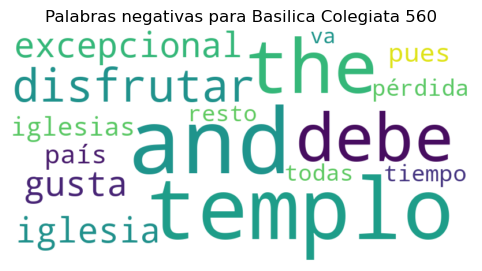

---------------
Gráfica para: Mercado Hidalgo 600


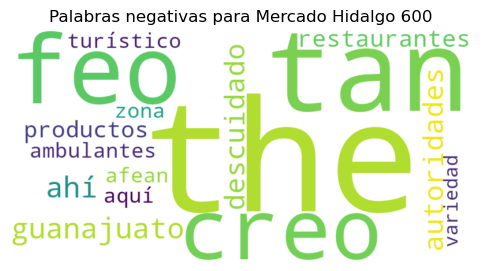

---------------
Gráfica para: Casa de Diego Rivera 698


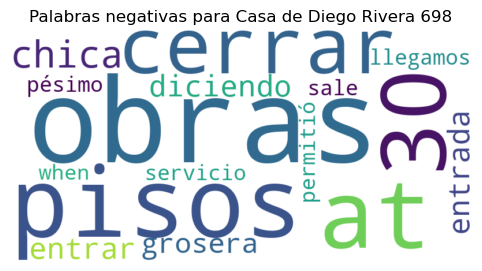

---------------
Gráfica para: Universidad de Guanajuato 900


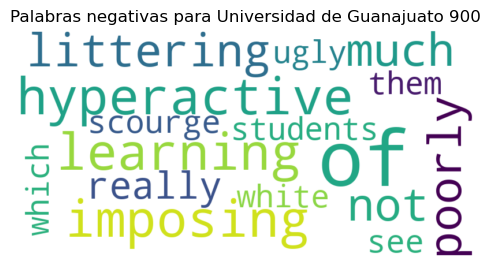

---------------
Gráfica para: Alhóndiga 930


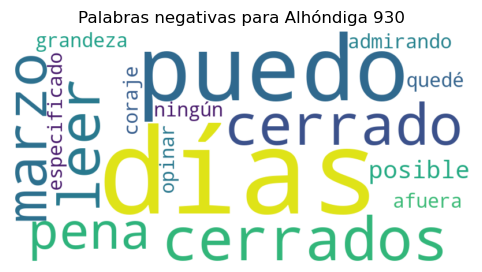

---------------
Gráfica para: Teatro Juárez 1,010


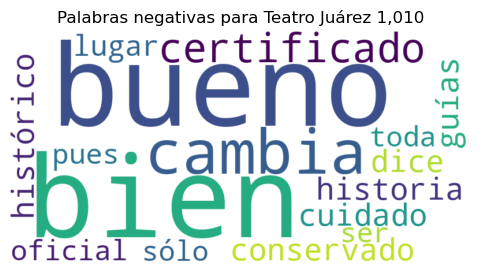

---------------
Gráfica para: Jardín de la Unión 1,134


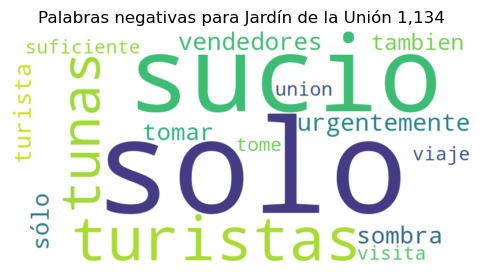

---------------
Gráfica para: Callejón del Beso 1,360


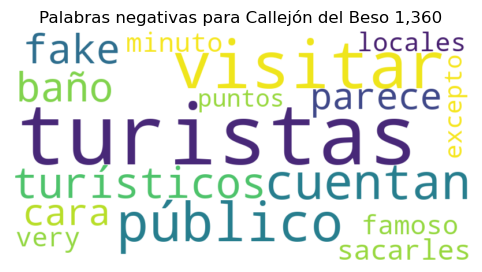

---------------
Gráfica para: Monumento Pípila 1,620


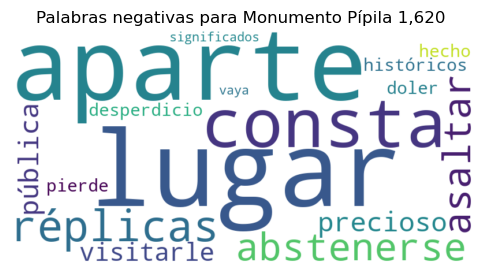

---------------
Gráfica para: Museo de las Momias 1,650


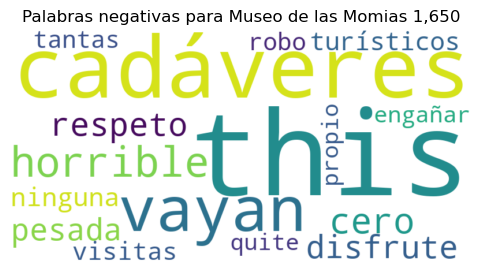

---------------


In [10]:
# Iteramos sobre cada lugar y su DataFrame en el diccionario
for lugar, df in dfs.items():
    print(f"Gráfica para: {lugar}")

    # Filtramos solo las opiniones negativas para el análisis
    neg_df = df[df['Escala'] < 3]
    word_freq = chiSquare(neg_df, nCaract=16)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(8, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Palabras negativas para {lugar}')
    plt.axis("off")
    plt.show()

    print("---------------")

**Discusión**

Utilizamos los 16 caracteres mas comunes ya que al hacer la reducción del corpus a las opiniones mas negativas se eliminaron muchas de las palabras y no era suficiente el número de características para el análisis. Es muy interesante analizar las opiniones mas negativas, te dice que es lo que la gente menciona mas de lo malo de los lugares. Este tipo de análisis podría dar una buena fuente de partida acerca de que aspectos mejorar, por ejemplo en el monumento al pipila una de las palabras es *asaltar* lo cual sugiere que puede que sea peligroso para transitar. Otro lugar puede ser el mercado Hidalgo que tiene una de sus palabras *descuidado*, lo cual sugiere una mejora en el mantenimiento del lugar.

**5. Para cada uno de los 10 sitios turísticos construya tres Bolsas de Palabras de la siguiente manera: i) 1000 términos con mayor peso tfidf, ii) 2000 bigramas con mayor tfidf, y iii) 1000 trigramas con mayor tfidf. Luego concatene las tres representaciones que fueron calculadas de forma independiente, con sus propios tfidfs según su espacio y su propio L2. Finalmente sobre todo ese espacio concatenado de 4000 características aplique ganancia de información o $\chi^2$ y obtenga los 1000 features más relevantes. Muestre una nube de palabras con el top 50 features relevantes para cada lugar turístico (10 nubes en total).**

Para poder realizar este ejercicio necesitamos generalizar las funciones construidas en los ejercicios pasados. (Tal vez debí haber hecho esto desde el principio). Es necesaria una función que construya una bolsa de palabras para distintos n-gramas, además de una función que concatene las tres bow. Otra función que clasifique utilizando $\chi^2$ y finalmente una que haga la nube de palabras. Todo para iterar sobre el dataframe y mostrar las nubes. Esto podría ser un dolor de cabeza pero afortunadamente tenemos las librería scikit por lo que podemos codear de manera mas sencilla.

In [11]:
# Función que genera una bow tfidf según n-gramas
def generate_bow(dataframe, ngram_range, max_features):

    # Selección de stopwords
    sw = stopwords.words('spanish') 

    # Generar la bow
    vectorizer = TfidfVectorizer(stop_words=sw, ngram_range=ngram_range, max_features=max_features)
    X = vectorizer.fit_transform(dataframe['Opinión'])
    return X, vectorizer.get_feature_names_out()

# Función que concatena bolsas de palabras
def concatenate_bows(df):

    # Generamos las diferentes bow
    X_uni, terms_uni = generate_bow(df, (1, 1), 1000)
    X_bi, terms_bi = generate_bow(df, (2, 2), 2000)
    X_tri, terms_tri = generate_bow(df, (3, 3), 1000)
    
    # Concatenamos
    X_combined = pd.concat([pd.DataFrame(X_uni.toarray()), pd.DataFrame(X_bi.toarray()), pd.DataFrame(X_tri.toarray())], axis=1)
    combined_terms = terms_uni.tolist() + terms_bi.tolist() + terms_tri.tolist()
    
    return X_combined, combined_terms

# Función que selecciona las mejores características
def select_features(X, y, combined_terms):
    selector = SelectKBest(chi2, k=1000)
    selector.fit(X, y)
    top_features = np.array(combined_terms)[selector.get_support()]
    
    return top_features

# Función que crea una nube de palabras
def create_wordcloud(features):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(features))
    plt.figure(figsize=(8, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

Gráfica para: Basilica Colegiata 560


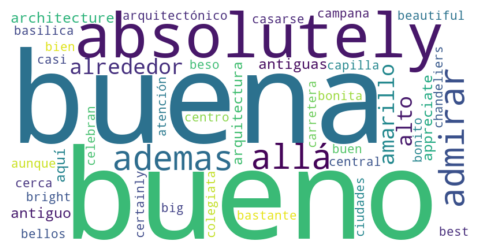

---------------
Gráfica para: Mercado Hidalgo 600


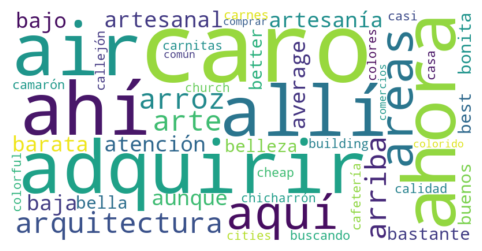

---------------
Gráfica para: Casa de Diego Rivera 698


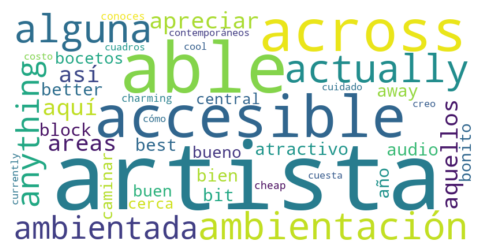

---------------
Gráfica para: Universidad de Guanajuato 900


---------------
Gráfica para: Alhóndiga 930


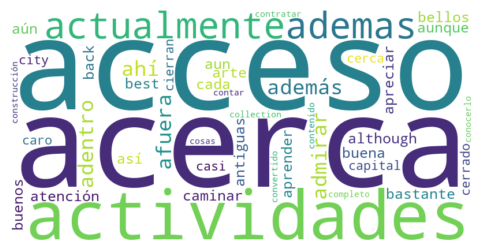

---------------
Gráfica para: Teatro Juárez 1,010


---------------
Gráfica para: Jardín de la Unión 1,134


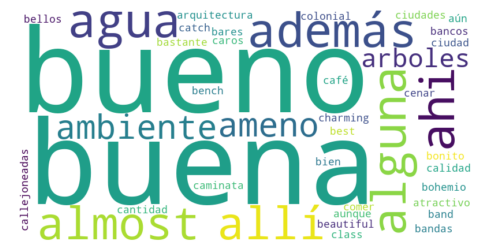

---------------
Gráfica para: Callejón del Beso 1,360


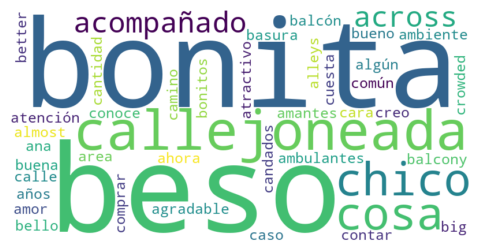

---------------
Gráfica para: Monumento Pípila 1,620


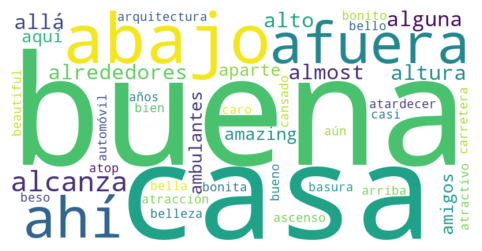

---------------
Gráfica para: Museo de las Momias 1,650


---------------


In [12]:
# Iteramos sobre cada lugar y su DataFrame en el diccionario
for lugar, df in dfs.items():
    print(f"Gráfica para: {lugar}")

    # Generamos la bow concatenada
    X_combined, combined_terms = concatenate_bows(df)

    # Seleccionar las top características
    top_features = select_features(X_combined, df['Escala'], combined_terms)

    # Graficamos
    create_wordcloud(top_features[:50])  # Visualizamos 50 palabras

    print("---------------")

**6. Diseñe un análisis temporal (formato libre) que muestre opiniones positivas, negativas y neutras a través de los meses y años para todos los sitios turísticos. En pocas palabras mostrar la evolución de las opiniones a través del tiempo.**

Para realizar un análisis temporal, podemos utilizar la fecha de las opiniones. Podemos revisar por ejemplo, la evolución de las opiniones, esto nos puede decir si el lugar ha mejorado con el tiempo o al contrario, esta en decremento.

Para poder realizar esto, necesitamos una función que procese los datos. Es decir hay que convertir las fechas y agrupar las opiniones ya que vamos a hacer una gráfica temporal de las opiniones. 

In [33]:
# Función que realiza una gráfica temporal de un dataframe
def plot_opinions(data, site):
    data['Mes-Año'] = data['Mes-Año'].astype(str)  # Convertir a string para visualización
    data.set_index('Mes-Año', inplace=True)
    
    # Gráfica
    ax = data[['Negativa', 'Neutra', 'Positiva']].plot(kind='bar', stacked=True, figsize=(14, 7))
    ax.set_title(f'Evolución de las Opiniones para {site}')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Número de Opiniones')
    ax.legend(title='Categoría')
    
    plt.xticks(rotation=60)
    plt.show()

# Función que categoriza las opiniones
def Analisis(df):
    # Categorizamos las opiniones
    df['Categoría'] = pd.cut(df['Escala'], bins=[0, 2, 3, 5], labels=['Negativa', 'Neutra', 'Positiva'], right=True)
    
    # Formateamos la fecha
    df['Fecha'] = pd.to_datetime(df['Fecha'])
    df['Mes-Año'] = df['Fecha'].dt.to_period('M')

    # Agrupamos el dataframe
    grouped = df.groupby(['Mes-Año', 'Categoría']).size().unstack(fill_value=0).reset_index()
    return grouped

Análisis para: Basilica Colegiata 560


/var/folders/9t/s_zg1kn954l26k1btcnp7lfm0000gn/T/ipykernel_36607/3907512951.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['Mes-Año', 'Categoría']).size().unstack(fill_value=0).reset_index()


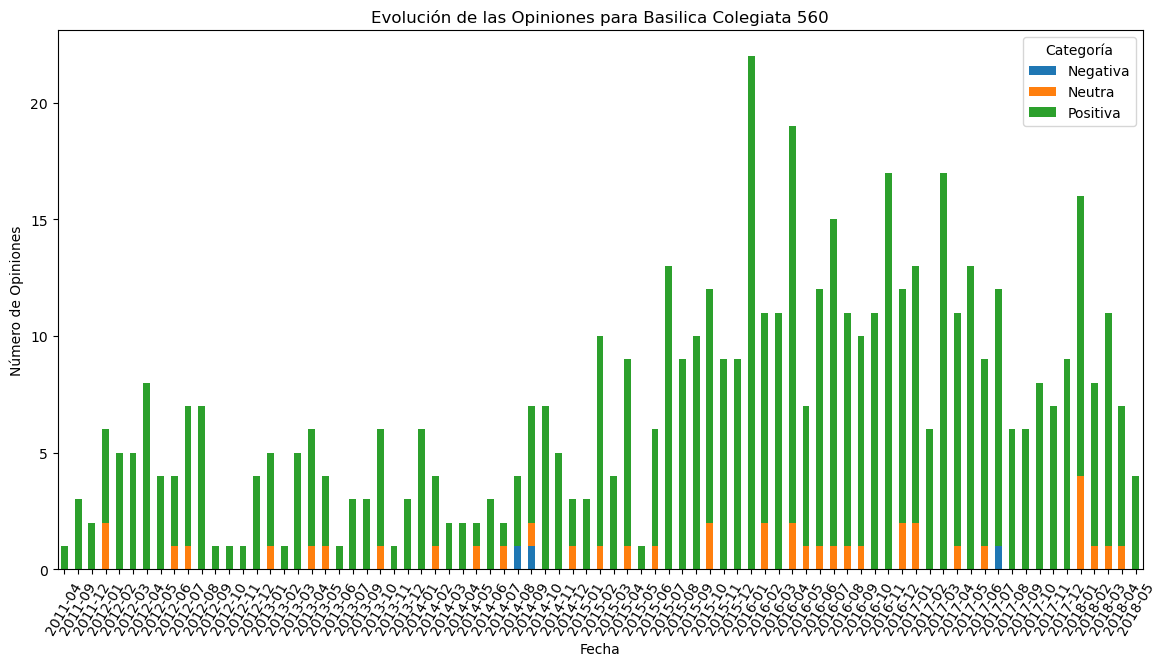

---------------
Análisis para: Mercado Hidalgo 600


/var/folders/9t/s_zg1kn954l26k1btcnp7lfm0000gn/T/ipykernel_36607/3907512951.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['Mes-Año', 'Categoría']).size().unstack(fill_value=0).reset_index()


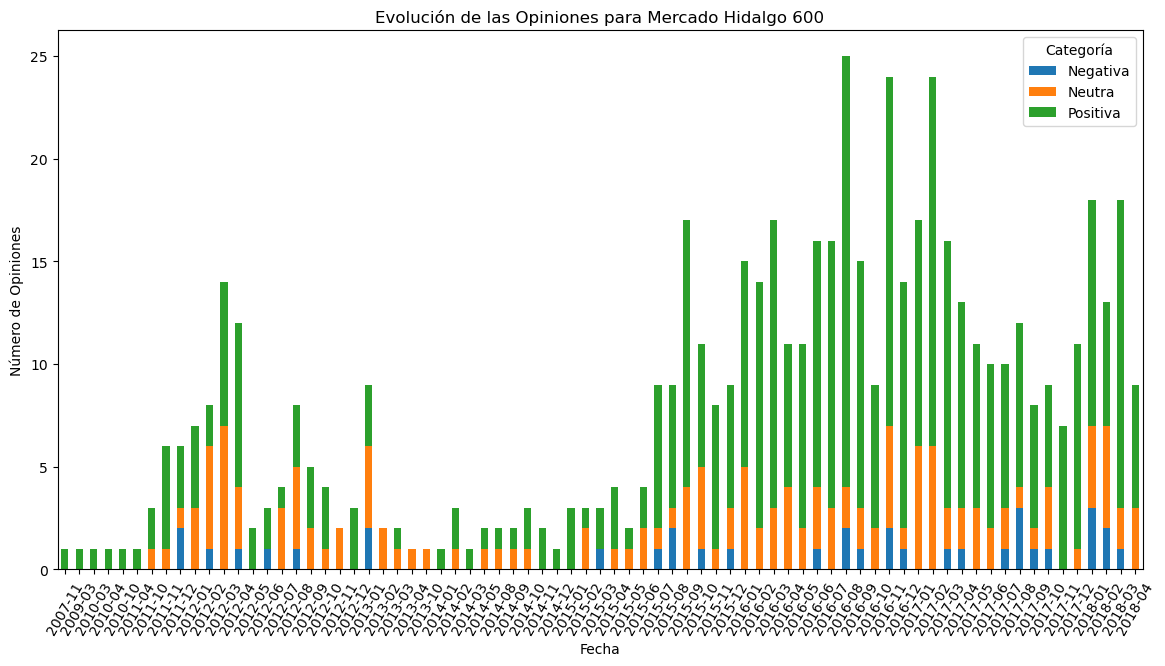

---------------
Análisis para: Casa de Diego Rivera 698


/var/folders/9t/s_zg1kn954l26k1btcnp7lfm0000gn/T/ipykernel_36607/3907512951.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['Mes-Año', 'Categoría']).size().unstack(fill_value=0).reset_index()


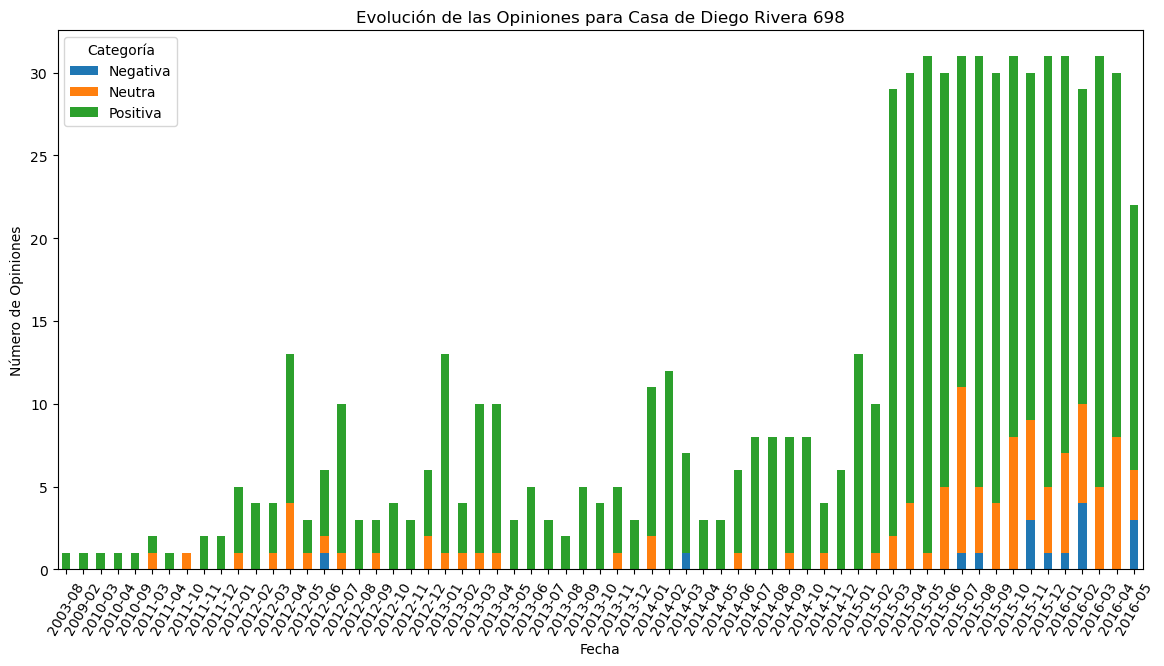

---------------
Análisis para: Universidad de Guanajuato 900


/var/folders/9t/s_zg1kn954l26k1btcnp7lfm0000gn/T/ipykernel_36607/3907512951.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['Mes-Año', 'Categoría']).size().unstack(fill_value=0).reset_index()


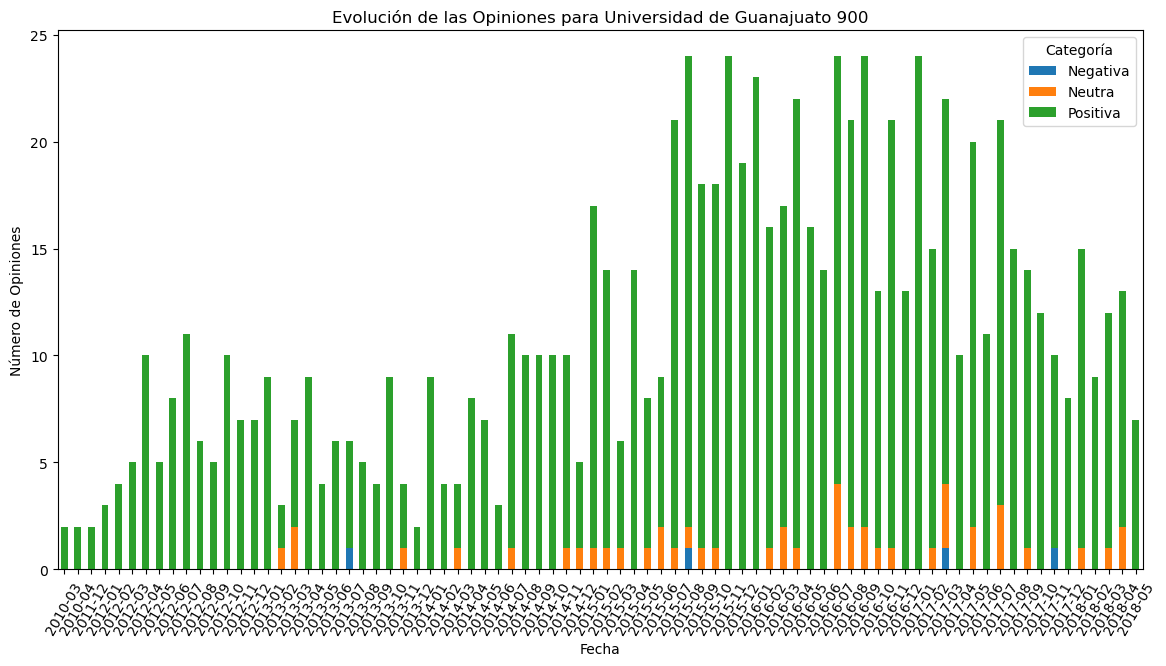

---------------
Análisis para: Alhóndiga 930


/var/folders/9t/s_zg1kn954l26k1btcnp7lfm0000gn/T/ipykernel_36607/3907512951.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['Mes-Año', 'Categoría']).size().unstack(fill_value=0).reset_index()


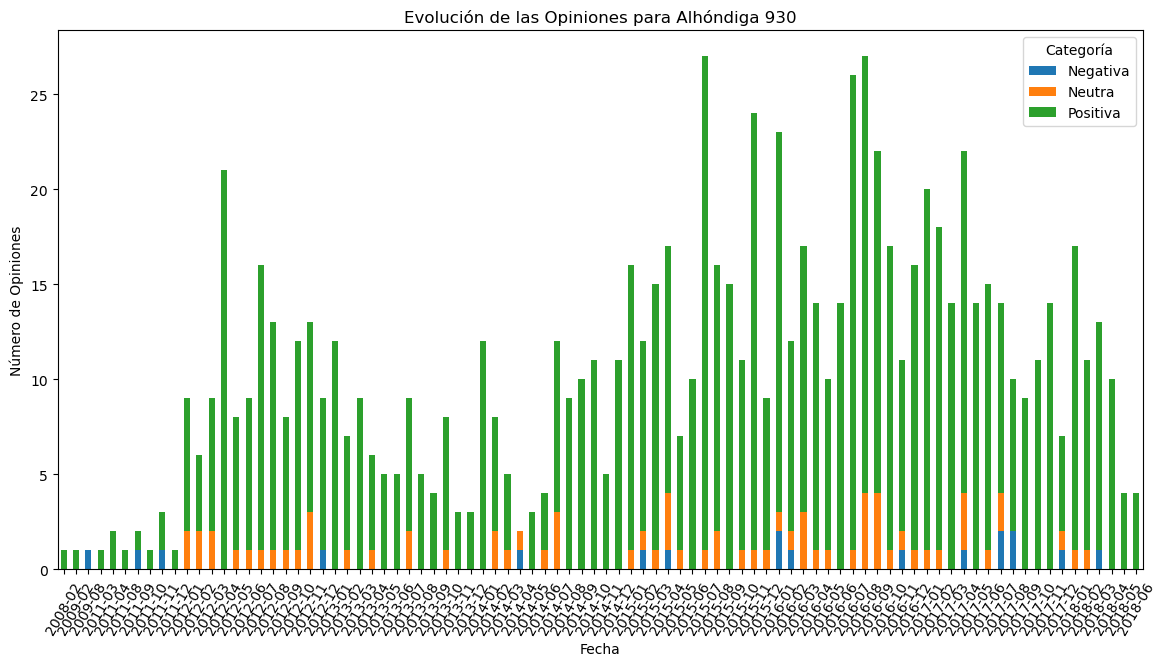

---------------
Análisis para: Teatro Juárez 1,010


/var/folders/9t/s_zg1kn954l26k1btcnp7lfm0000gn/T/ipykernel_36607/3907512951.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['Mes-Año', 'Categoría']).size().unstack(fill_value=0).reset_index()


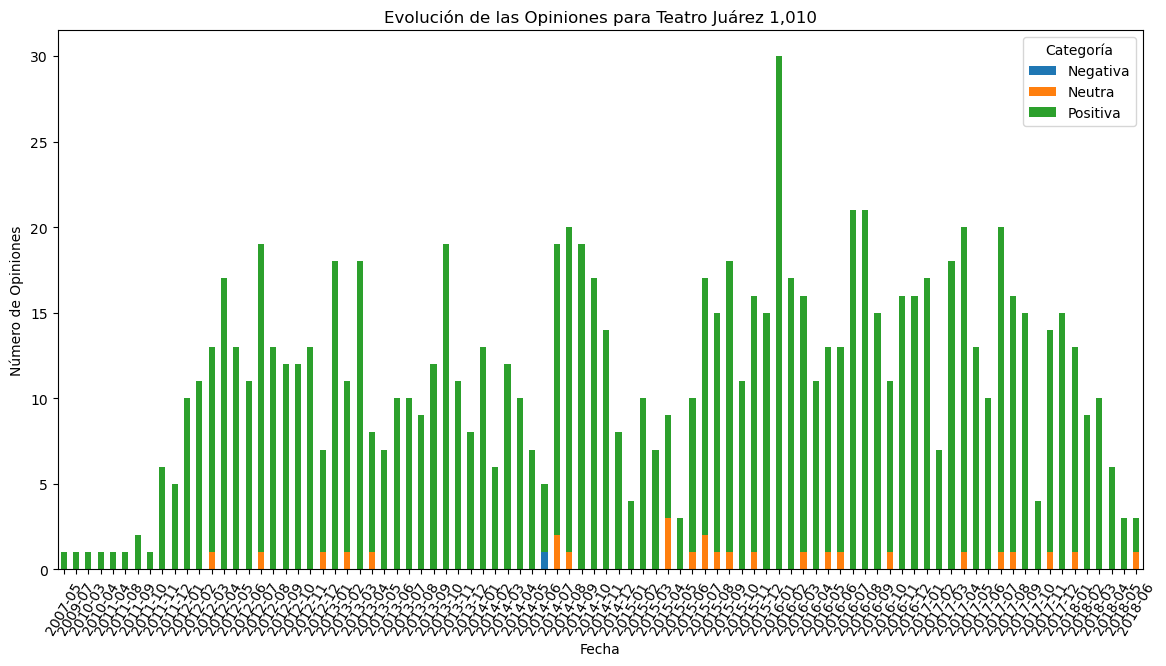

---------------
Análisis para: Jardín de la Unión 1,134


/var/folders/9t/s_zg1kn954l26k1btcnp7lfm0000gn/T/ipykernel_36607/3907512951.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['Mes-Año', 'Categoría']).size().unstack(fill_value=0).reset_index()


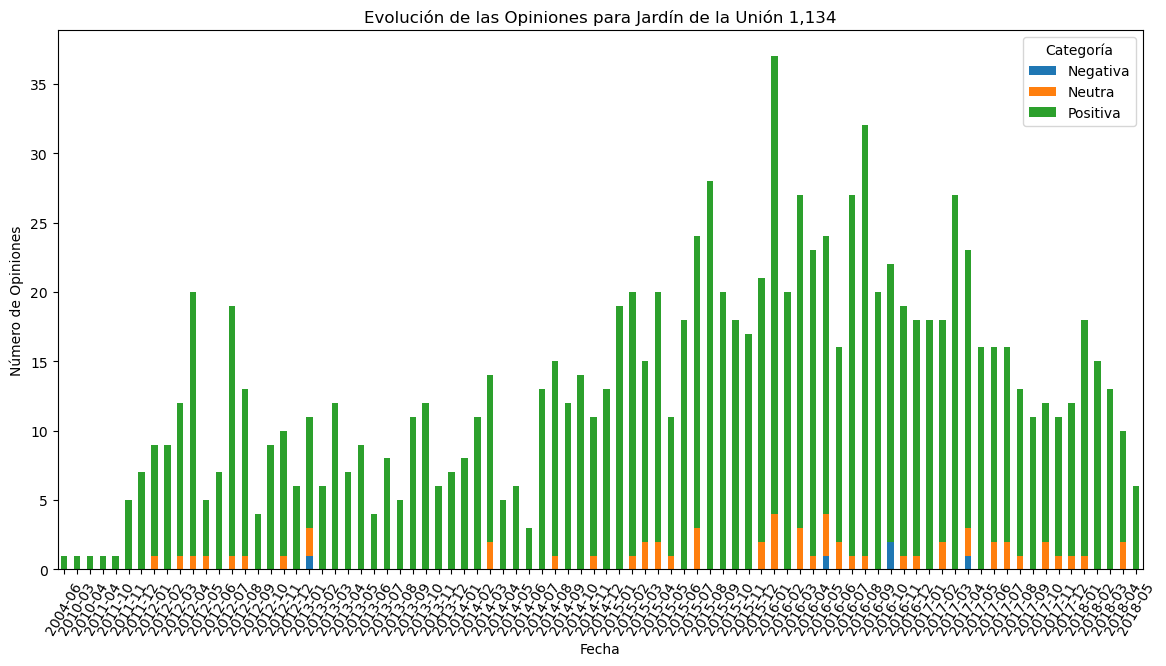

---------------
Análisis para: Callejón del Beso 1,360


/var/folders/9t/s_zg1kn954l26k1btcnp7lfm0000gn/T/ipykernel_36607/3907512951.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['Mes-Año', 'Categoría']).size().unstack(fill_value=0).reset_index()


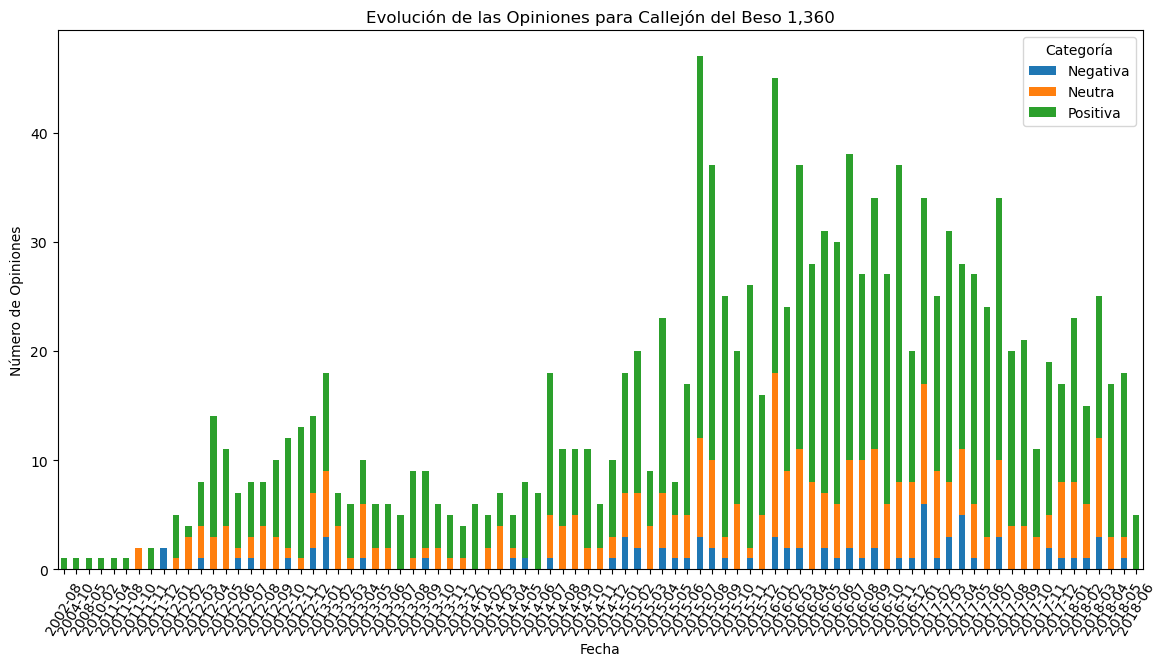

---------------
Análisis para: Monumento Pípila 1,620


/var/folders/9t/s_zg1kn954l26k1btcnp7lfm0000gn/T/ipykernel_36607/3907512951.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['Mes-Año', 'Categoría']).size().unstack(fill_value=0).reset_index()


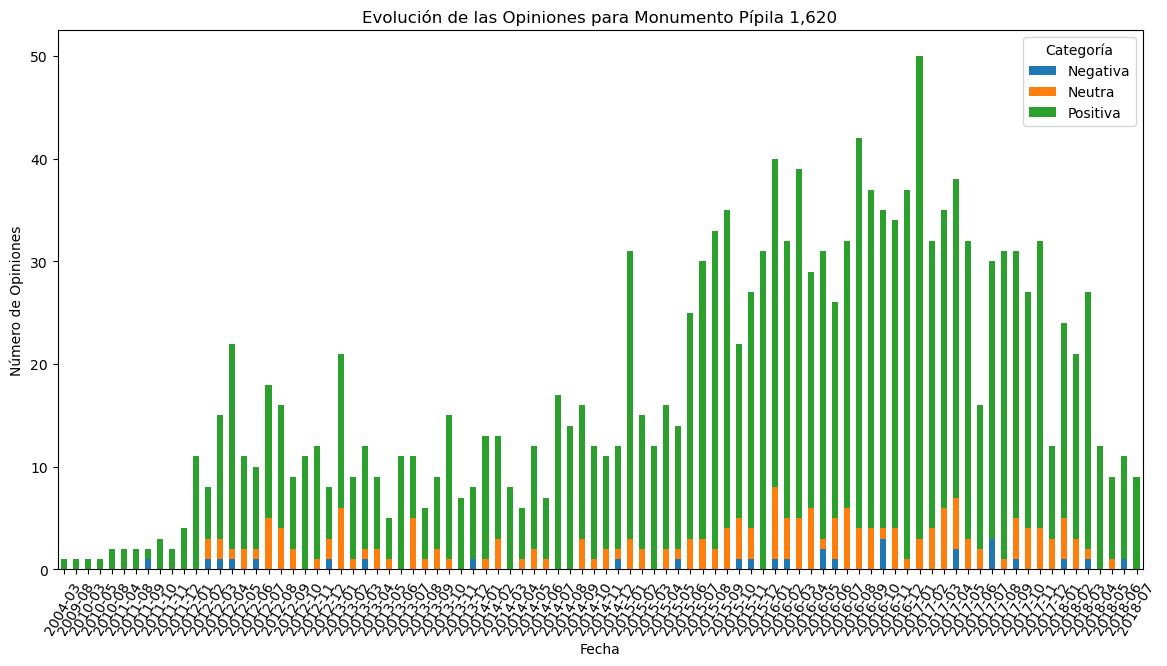

---------------
Análisis para: Museo de las Momias 1,650


/var/folders/9t/s_zg1kn954l26k1btcnp7lfm0000gn/T/ipykernel_36607/3907512951.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['Mes-Año', 'Categoría']).size().unstack(fill_value=0).reset_index()


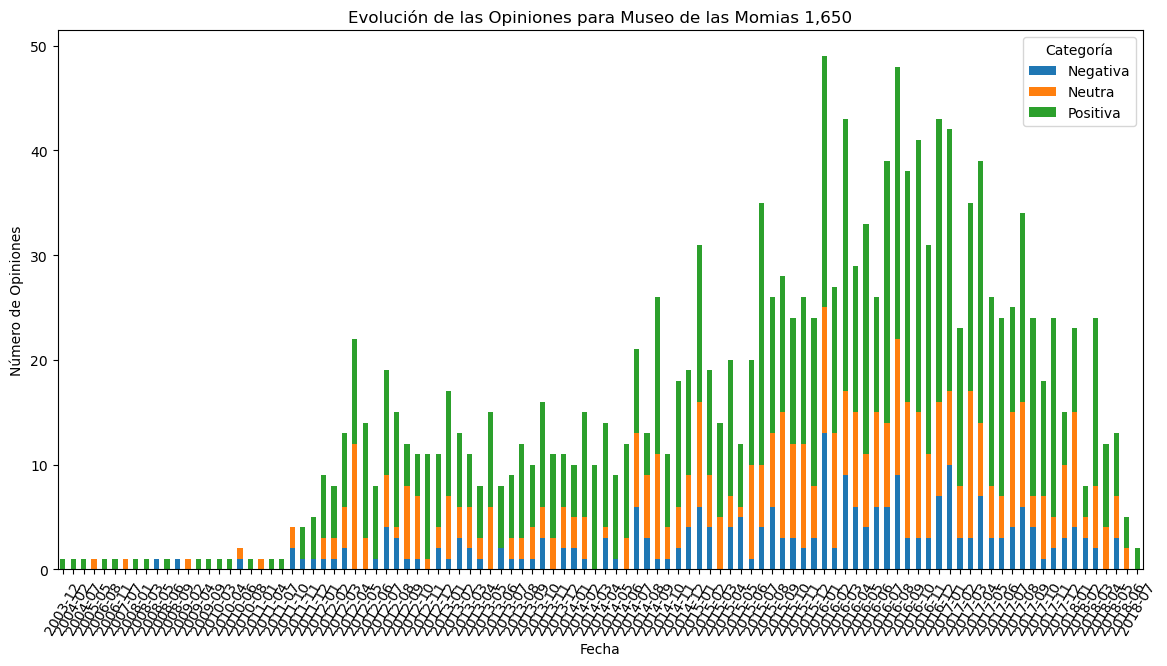

---------------


In [34]:
# Iteramos sobre cada lugar y su DataFrame en el diccionario
for lugar, df in dfs.items():
    print(f"Análisis para: {lugar}")

    # Conseguimos al data frame agrupado
    grouped_df = Analisis(df)

    # Graficamos
    plot_opinions(grouped_df, lugar)

    print("---------------")

**Discusión**.

Las gráficas no solo muestran una evolución temporal de las opiniones de los visitantes, sino que muestran como ha ido aumentando o disminuyendo la cantidad de visitantes en los sitios turísticos. Por ejemplo, en la casa Diego Rivera, algo paso en febrero de 2015 que aumento muchísimo la cantidad de opiniones. La mayoría de los lugares tienden a un aumento en sus opiniones esto claro, por el aumento en la tecnología con los años. Hay un lugar el cual no ha ido aumentando su número de opiniones, sino que parece constante, y es el que a mi parecer es el lugar mas turístico y popular, *el teatro juarez*. En cuanto al análisis de opinión, parece que el sitio con mas opiniones negativas es el *museo de las momias*, lo cual va acorde con el análisis de sentimientos realizado en el ejercicio 1. Parece que en todos los sitios es una constante el número de opiniones positivas, neutras y negativas con los años, este análisis funciona para los sitios en lo que se necesita trabajar para cambiar las opiniones neutras en positivas y las negativas en neutras poco a poco. No hay un indicativo en el timelaps de las gráficas de que esto sea asi, pero se un buen punto de partida.

## Preguntas



**1. ¿De los sitios turísticos, cual diría usted que es el más polémico y la razón de ello?**

A mi parecer es el museo de las momias, tanto en el análisis de sentimientos, es decir el promedio de las opiniones, tanto como en la gráfica de evolución temporal parece ser el sitio con las opiniones mas negativas. Me pareció sorprendente que aún asi, el promedio es muy alto, y la mayoría de las opiniones tienden a ser positivas, lo cual indica que todos los sitios revisados generalmente tienen muy buenas opiniones de los turistas, siendo Guanajuato una ciudad bastante popular en ese sentido.

**2. En cuanto al sitio más polémico, ¿Como es la diferencia de opinión y temas entre turistas nacionales e internacionales?**

Según el test realizado en el ejercicio 1, el museo de las momias tiene una calificación ligeramente superior entre los visitantes internacionales, de hecho en las nubes de palabras asociadas a opiniones negativas, aparecen menos palabras en inglés que en español para ese lugar. Esto puede ser explicado ya que es algo no muy común de ver en los extranjeros, y tal vez parece mucho mejor en comparación de los nacionales que pueden volver mas fácilmente.

**3. ¿Cual diría que es el sitio que le gusta más a las mujeres y por qué?**

Según el análisis por grupos en LSA las mujeres tienden a buscar los lugares con una belleza mas arquitectónica como por ejemplo el teatro Juarez o la Universidad de Guanajuato. Yo diría que lo que les gusta mas a las mujeres es el *teatro Juarez*.

**4. ¿Cual diría que es el sitio que le gusta más a las personas jóvenes y por qué?**

Según el análisis LSA el *Mercado Hidalgo* podría considerarse como el sitio que más gusta a las personas jóvenes, ya que las palabra que destacan están relacionadas con la comida, las artesanías y la experiencia de compra. Este mercado proporciona una experiencia cultural rica y accesible que permite a los jóvenes interactuar directamente con la cultura.

**5. ¿Qué otras observaciones valiosas puede obtener de su análisis? (e.g., ¿identificó de que se queja la gente? ¿qué tipo de cosas le gustó a la gente?, etc.)**

Algo que me pareció super interesante fueron las palabras en las nubes de palabras de opiniones negativas. Estas palabras proporcionan (insights) o indicativos de lo que puede estar pasando de manera negativa, que a mi parecer es lo que se puede mejorar. Por ejemplo la inseguridad en el pipila, o la limpieza en lugares como el museo de momias o el jardín de la unión. Creo que los análisis de grupos también proporcionan buenas recomendaciones si se quiere atraer un público objetivo como en el caso de hombres o mujeres, o por ejemplo en el caso de turistas internacionales. Se me ocurren los lugar que son mas visitados por internacionales por ejemplo el jardín de la unión que se menciona la palabra *restaurants* en el análisis LSA y la palabra *sucio* en las nubes, se puede mejorar la limpieza de este lugar para atraer mas a los turistas internacionales. Usualmente a la gente le gusta lo arquitectónico y lo bonito de los lugares. Este tipo de análisis me gusta bastante ya que podemos encontrar conclusiones fascinantes y mejoras inmediatas en base a la opinión de las personas.  